In [1]:
import numpy as np
import matplotlib.pyplot as plt

import starspot as ss

import numpyro
numpyro.set_host_device_count(2)

import jax
import jax.numpy as jnp

import lightkurve as lk

import astropy.units as u

jax.config.update("jax_enable_x64", True)


/Users/benjaminpope/opt/anaconda3/envs/starspot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/benjaminpope/opt/anaconda3/envs/starspot/lib/python3.11/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/benjaminpope/.lightkurve/cache. Please move all the files in the legacy directory /Users/benjaminpope/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
# Load some data
search = lk.search_lightcurve('StKM 1-1262',mission='TESS',exptime=120)
print(search)

SearchResult containing 5 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 16 2019   SPOC     120   235568605      0.0
  1 TESS Sector 23 2020   SPOC     120   235568605      0.0
  2 TESS Sector 24 2020   SPOC     120   235568605      0.0
  3 TESS Sector 49 2022   SPOC     120   235568605      0.0
  4 TESS Sector 51 2022   SPOC     120   235568605      0.0


Number of data points: 2030


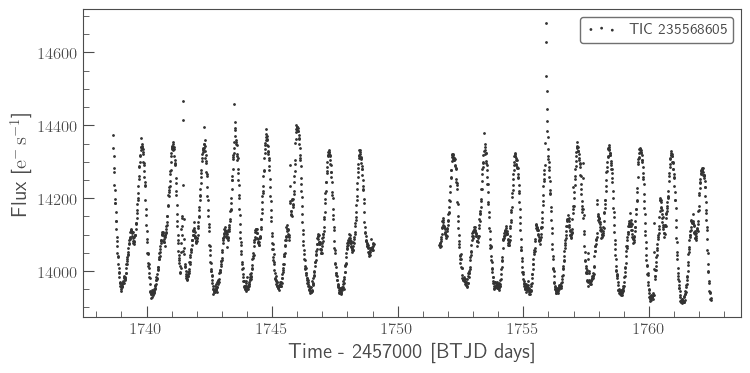

In [3]:
lc = search[0].download().remove_nans().remove_outliers().bin(time_bin_size=15*u.min).remove_nans().remove_outliers()
lc = lc[lc.quality==0]
print('Number of data points:', len(lc.time))
lc.scatter()
plt.show()

In [4]:
time, flux, flux_err = lc.time.value.astype(np.float64), np.array(lc.flux.value).astype(np.float64), np.array(lc.flux_err.value).astype(np.float64)

In [5]:

rotate = ss.RotationModel(time, flux, flux_err)


In [6]:

# Calculate the Lomb Scargle periodogram period (highest peak in the periodogram).
lomb_scargle_period = rotate.ls_rotation()


In [7]:

# Calculate the autocorrelation function (ACF) period (highest peak in the ACF).
# This is for evenly sampled data only -- time between observations is 'interval'.
acf_period = rotate.acf_rotation(interval=np.diff(time)[0])
print(acf_period)

1.2395833333423525


In [8]:

# Calculate the phase dispersion minimization period (period of lowest dispersion).
period_grid = np.linspace(0.5, 2, 1000)
pdm_period, pdm_err = rotate.pdm_rotation(period_grid)

print(lomb_scargle_period, acf_period, pdm_period)
# >> 9.99892010582963 10.011001100110011 10.0


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1293.72it/s]

1.2381875724346973 1.2395833333423525 1.2402402402402402


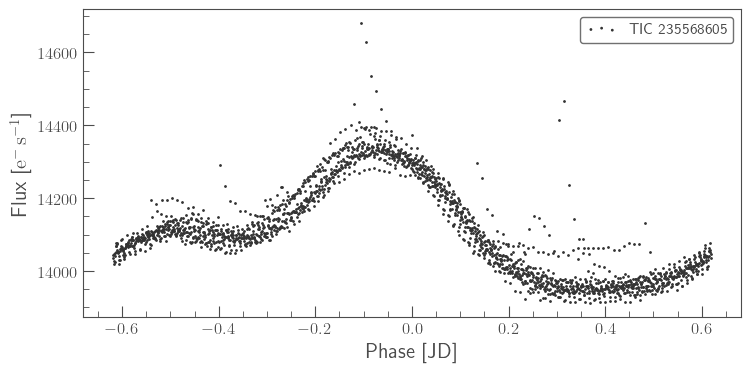

In [9]:
lc_folded = lc.fold(period=lomb_scargle_period);
lc_folded.scatter()
plt.show()

So! The ACF, PDM, and LS periods work fine! Just the GP bit to worry about.

In [10]:

# Calculate a Gaussian process rotation period
gp_period = rotate.gp_rotation()

Sampling


Running chain 1: 100%|██████████| 4000/4000 [06:11<00:00, 10.76it/s]


GP Period: 1.164 + 0.124 - 0.089


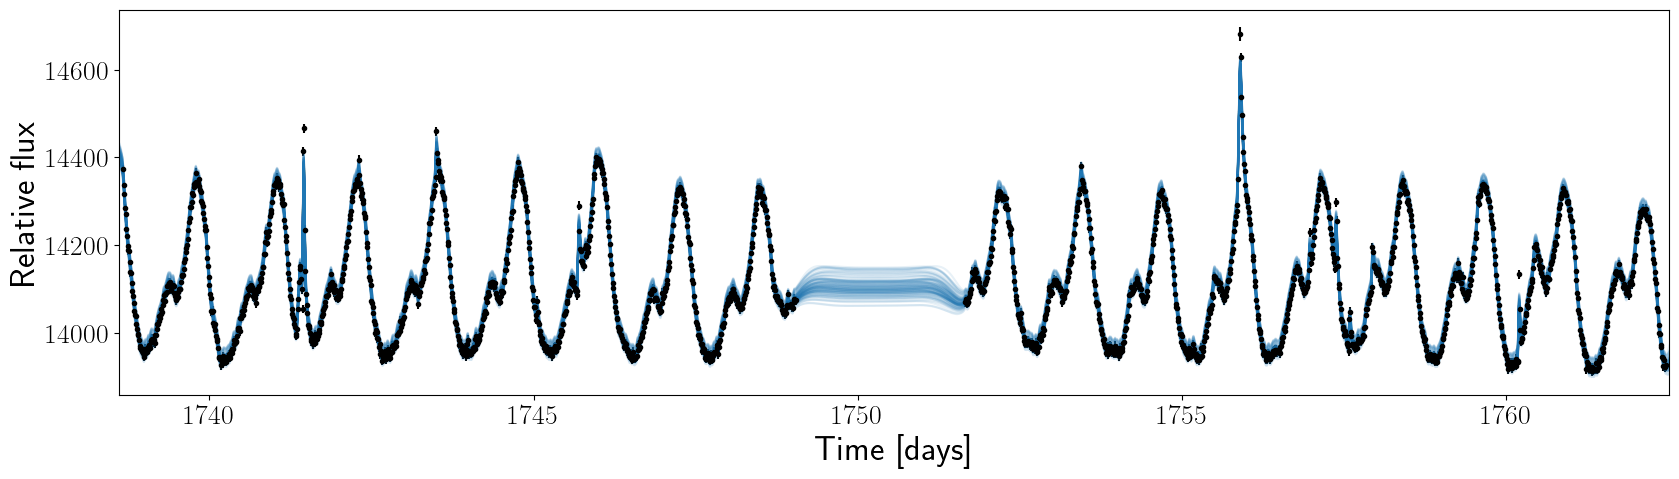

In [11]:
rotate.plot_prediction()

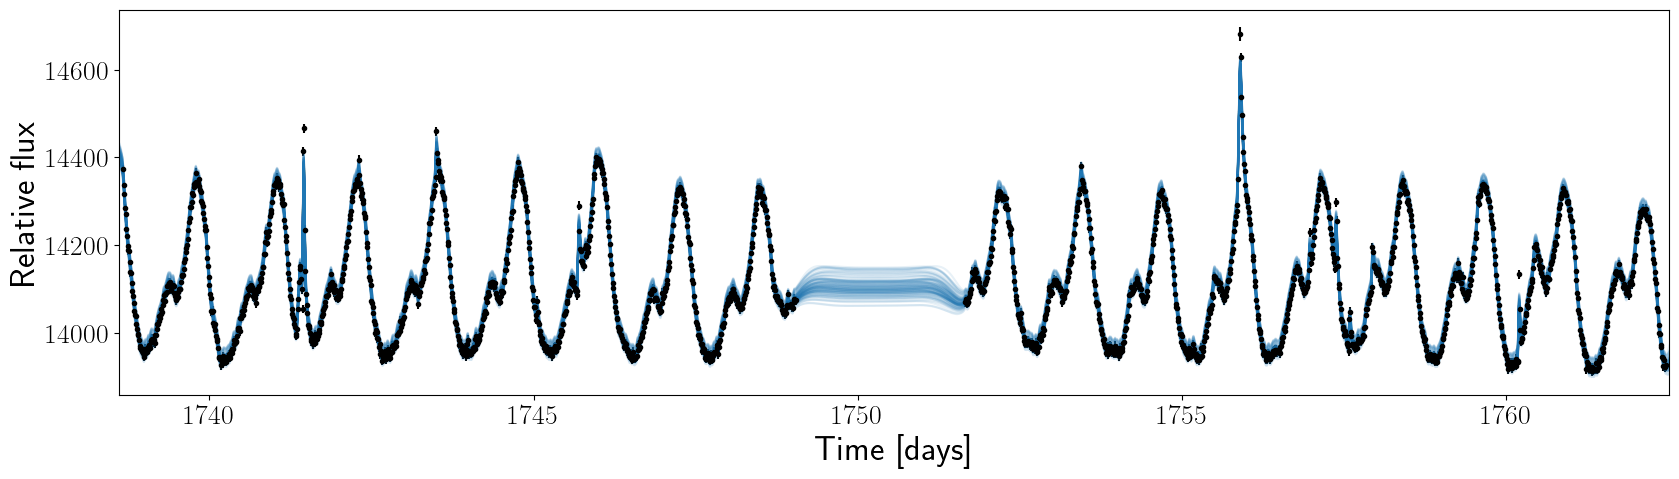

<Figure size 2000x500 with 0 Axes>

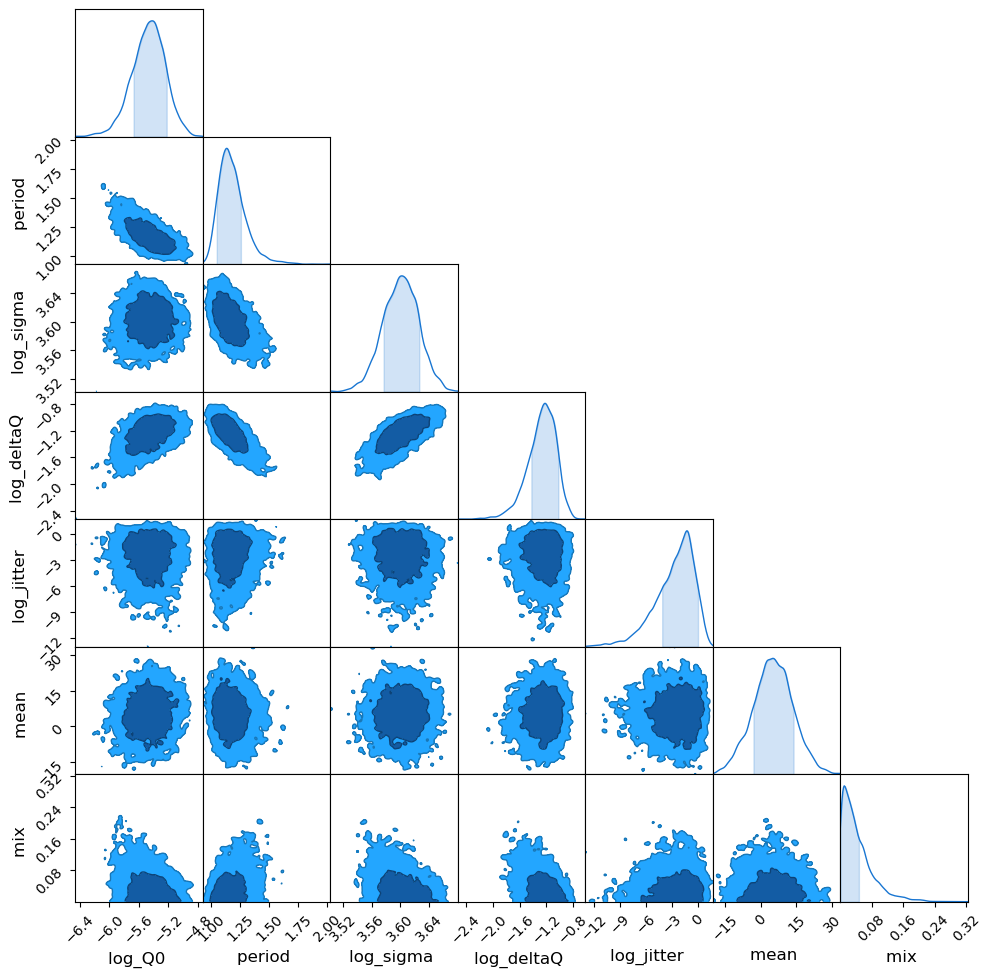

<Figure size 2000x500 with 0 Axes>

In [12]:
rotate.plot_posterior()